<span style="color:orange; font-weight:bold">Note: To answer questions based on text documents, we recommend the procedure in <a href="https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb">Question Answering using Embeddings</a>. Some of the code below may rely on <a href="https://github.com/openai/openai-cookbook/tree/main/transition_guides_for_deprecated_API_endpoints">deprecated API endpoints</a>.</span>

# 1. Collect Wikipedia data about Olympic Games 2020

The idea of this project is to create a question answering model, based on a few paragraphs of provided text. Base GPT-3 models do a good job at answering questions when the answer is contained within the paragraph, however if the answer isn't contained, the base models tend to try their best to answer anyway, often leading to confabulated answers. 

To create a model which answers questions only if there is sufficient context for doing so, we first create a dataset of questions and answers based on paragraphs of text. In order to train the model to answer only when the answer is present, we also add adversarial examples, where the question doesn't match the context. In those cases, we ask the model to output "No sufficient context for answering the question". 

We will perform this task in three notebooks:
1. The first (this) notebook focuses on collecting recent data, which GPT-3 didn't see during it's pre-training. We picked the topic of Olympic Games 2020 (which actually took place in the summer of 2021), and downloaded 713 unique pages. We organized the dataset by individual sections, which will serve as context for asking and answering the questions.
2. The [second notebook](olympics-2-create-qa.ipynb) will utilize Davinci-instruct to ask a few questions based on a Wikipedia section, as well as answer those questions, based on that section.
3. The [third notebook](olympics-3-train-qa.ipynb) will utilize the dataset of context, question and answer pairs to additionally create adversarial questions and context pairs, where the question was not generated on that context. In those cases the model will be prompted to answer "No sufficient context for answering the question". We will also train a discriminator model, which predicts whether the question can be answered based on the context or not.

The notebook was originally released from OpenAI repository, see [here](https://github.com/openai/openai-cookbook/tree/main/examples/fine-tuned_qa). However, we advise to play around with keywords and search records of any Wikipedia pages. Hence, we editted this notebook as a demonstration purpose.

## 1.1 Data extraction using the wikipedia API
Extracting the data will take about half an hour, and processing will likely take about as much.

In [1]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=eec2e8c869c1c95175a935b7471717bdf9c300f32bbed269ece0bba84653d5b6
  Stored in directory: /root/.cache/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia


In [20]:
import pandas as pd
import wikipedia


def filter_titles(titles):
    """
    Get the titles which are related to a topic titles
    """
    titles = [title for title in titles if 'clinical' in title or 'trials' in title.lower() or 'medical' in title.lower()]
    
    return titles

def get_wiki_page(title):
    """
    Get the wikipedia page given a title
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

def recursively_find_all_pages(titles, titles_so_far=set()):
    """
    Recursively find all the pages that are linked to the Wikipedia titles in the list
    """
    all_pages = []
    
    titles = list(set(titles) - titles_so_far)
    titles = filter_titles(titles)
    print(titles, len(titles))
    titles_so_far.update(titles)
    for title in titles:
        try:
            page = get_wiki_page(title)
        except:
            print("Page not found.")
        if page is None:
            continue
        all_pages.append(page)

        try:
            new_pages = recursively_find_all_pages(page.links, titles_so_far)
            for pg in new_pages[::10]:
                if pg.title not in [p.title for p in all_pages]:
                    all_pages.append(pg)
            titles_so_far.update(page.links)
        except:
            print("Recursive page found error.")
    return all_pages


In [21]:
pages = recursively_find_all_pages(["clinical trial"])
len(pages)

['clinical trial'] 1
['Medical procedure', 'Pre-existing medical conditions', 'Medical diagnosis', 'Trials (journal)', 'List of clinical research topics', 'Phases of clinical research', 'Adaptive clinical trial', 'Medical laboratory', 'Academic clinical trials', 'Medical nutrition therapy', 'Clinical trials publication', 'Medical Research Council (United Kingdom)', 'Monitoring in clinical trials', 'Ethical problems using children in clinical trials', 'Clinicaltrials.gov', 'Glossary of clinical research', 'British Medical Association', 'Clinical Trials (journal)', 'Children in clinical research', 'ClinicalTrials.gov', 'Clinical Trials', 'Analysis of clinical trials', 'Pregnant women in clinical research', 'Biologic medical product', 'Medical statistics', 'Medical device'] 26
['Medical imaging', 'Invasive (medical)', 'Guideline (medical)', "Stedman's Medical Dictionary", 'Algorithm (medical)', 'Medical error', 'Medical inspection', 'Consensus (medical)', 'Medical prescription', "Dorland'

/usr/local/lib/python3.9/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.9/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Streaming output truncated to the last 5000 lines.
["Children's National Medical Center", 'Shaikh Zayed Medical College and Hospital'] 2
['Washington DC VA Medical Center', 'Emergency Medical Services for Children', 'Walter Reed Army Medical Center', 'United Medical Center'] 4
['Oscar G. Johnson VA Medical Center', 'Michael E. DeBakey VA Medical Center', 'Medical community of ancient Rome', 'Dayton Veterans Affairs Medical Center', 'William Jennings Bryan Dorn Veterans Affairs Medical Center', 'Manchester VA Medical Center', 'San Francisco VA Medical Center', 'List of Veterans Affairs medical facilities by state', 'Veterans Affairs Medical Center (Oregon)', 'Marion Veterans Affairs Medical Center', 'Salem Veterans Affairs Medical Center'] 11
[] 0
[] 0
['Speculum (medical)'] 1
['Retractor (medical)', 'Single-use medical devices'] 2
[] 0
['Single use medical device reprocessing'] 1
[] 0
['List of Veterans Affairs medical facilities'] 1
[] 0
[] 0
['Dartmouth Medical School'] 1
['Santa Cla

5

In [23]:
len(pages)

5

## 1.2 Filtering the Wikipedia pages and splitting them into sections by headings
We remove sections unlikely to contain textual information, and ensure that each section is not longer than the token limit

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.9 MB/s eta 0:00:00


In [26]:
import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a Wikipedia page, discarding the references and other low information sections
    """
    if len(wiki_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs


In [27]:
# Example page being processed into sections
bermuda_page = get_wiki_page('clinical')
ber = extract_sections(bermuda_page.content, bermuda_page.title)

# Example section
ber[-1]


/usr/local/lib/python3.9/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.9/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


('List of medical schools in the United States',
 'Developing medical schools',
 'The following medical schools are under "applicant" or "candidate" status with either COCA or LCME.',
 30)

### 1.2.1 We create a dataset and filter out any sections with fewer than 40 tokens, as those are unlikely to contain enough context to ask a good question.

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
# df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

,title,heading,content,tokens
0,Clinical trial,Summary,Clinical trials are prospective biomedical or ...,292
1,Clinical trial,Overview,,2
2,Clinical trial,Trials of drugs,Some clinical trials involve healthy subjects ...,682
3,Clinical trial,Trials of devices,"Similarly to drugs, manufacturers of medical d...",130
4,Clinical trial,Trials of procedures,"Similarly to drugs, medical or surgical proced...",60


In [32]:
df.shape

(80, 4)

### Save the section dataset
We will save the section dataset, for the [next notebook](olympics-2-create-qa.ipynb)

In [33]:
# df.to_csv('olympics-data/olympics_sections.csv', index=False)
df.to_csv('clinical_trials.csv', index=False)

## 1.3 (Optional) Exploring the data 

In [34]:
df.title.value_counts().head()

Clinical trial               41
Preregistration (science)    14
Medical laboratory           11
Medical procedure             9
Medical statistics            5
Name: title, dtype: int64

There appear to be winter and summer Olympics 2020. We chose to leave a little ambiguity and noise in the dataset, even though we were interested in only Summer Olympics 2020.

In [ ]:
df.title.str.contains('Summer').value_counts()

True     3661
False     255
Name: title, dtype: int64

In [ ]:
df.title.str.contains('Winter').value_counts()

False    3795
True      121
Name: title, dtype: int64

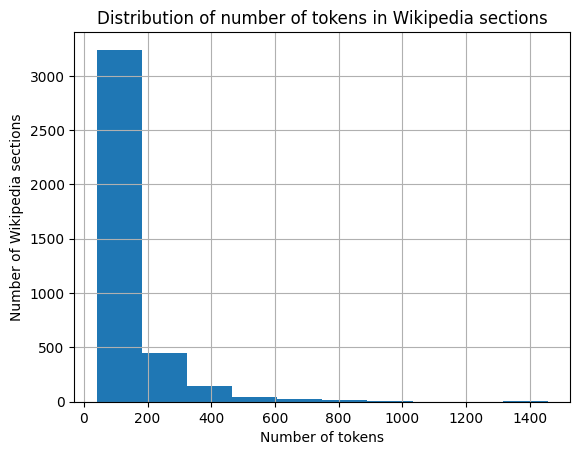

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

# df = pd.read_csv('olympics-data/olympics_sections.csv')
df = pd.read_csv('olympics_sections.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()

We can see that the majority of section are fairly short (less than 500 tokens).